# Setup & BigQuery Connection Test

**Objectives:**
1. Test Python environment setup
2. Verify all required libraries are installed
3. Test BigQuery connection
4. Validate access to Olist marts
5. Run sample queries to confirm data availability

## 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from google.cloud import bigquery

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("All libraries imported successfully!")
print(f"Execution date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

All libraries imported successfully!
Execution date: 2025-12-17 11:48:22


## 2. Check Library Versions

In [3]:
import sys

print("=" * 60)
print("PYTHON ENVIRONMENT INFO")
print("=" * 60)
print(f"Python version: {sys.version.split()[0]}")  # Mostra apenas o número
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Plotly version: {px.__version__ if hasattr(px, '__version__') else 'Atributo não disponível'}")
print(f"Seaborn version: {sns.__version__}")
print(f"BigQuery SDK version: {bigquery.__version__}")
print("=" * 60)

PYTHON ENVIRONMENT INFO
Python version: 3.13.5
Pandas version: 2.3.3
NumPy version: 2.3.5
Plotly version: Atributo não disponível
Seaborn version: 0.13.2
BigQuery SDK version: 3.39.0


## 3. Configure BigQuery Connection

In [ ]:
import os
from google.cloud import bigquery  

caminho_credencial = r"C:\projects-git\quintoandar-ecommerce-analysis\credentials\bigquery-key.json"

if os.path.exists(caminho_credencial):
    print(f"Credencial encontrada: {caminho_credencial}")
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = caminho_credencial
else:
    print(f"ERROR: Arquivo NÃO encontrado!")
    exit()

PROJECT_ID = "quintoandar-ecommerce-analysis"
DATASET_RAW = "olist_raw"
DATASET_STAGING = "olist_staging"
DATASET_MARTS = "olist_marts"

try:
    client = bigquery.Client(project=PROJECT_ID)  
    print(f"BigQuery client initialized successfully!")
    print(f"Project ID: {PROJECT_ID}")
    print(f"Default location: {client.location or 'US'}")
except Exception as e:
    print(f"Error initializing BigQuery client: {e}")
    print("\nMake sure GOOGLE_APPLICATION_CREDENTIALS is set correctly")

✅ Credencial encontrada: C:\projects-git\quintoandar-ecommerce-analysis\credentials\bigquery-key.json
BigQuery client initialized successfully!
Project ID: quintoandar-ecommerce-analysis
Default location: US


## 4. Test BigQuery Connection

In [7]:
def test_bigquery_connection():
    """Test basic BigQuery connectivity"""
    try:
        query = """
        SELECT 
            CURRENT_TIMESTAMP() as test_timestamp,
            'Connection successful!' as message
        """
        
        df = client.query(query).to_dataframe()
        
        print("=" * 60)
        print("BIGQUERY CONNECTION TEST")
        print("=" * 60)
        print(df)
        print("=" * 60)
        print("BigQuery connection is working!")
        return True
    except Exception as e:
        print(f"BigQuery connection failed: {e}")
        return False

test_bigquery_connection()

C:\projects-git\quintoandar-ecommerce-analysis\venv\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


BIGQUERY CONNECTION TEST
                    test_timestamp                 message
0 2025-12-17 15:03:38.110310+00:00  Connection successful!
BigQuery connection is working!


True

## 5. List Available Datasets

In [8]:
def list_datasets():
    """List all datasets in the project"""
    try:
        datasets = list(client.list_datasets())
        
        print("=" * 60)
        print("AVAILABLE DATASETS")
        print("=" * 60)
        
        if datasets:
            for dataset in datasets:
                dataset_id = dataset.dataset_id
                dataset_ref = client.get_dataset(dataset_id)
                tables = list(client.list_tables(dataset_id))
                table_count = len(tables)
                
                print(f"{dataset_id}")
                print(f"   └─ Tables: {table_count}")
                print(f"   └─ Location: {dataset_ref.location}")
                print(f"   └─ Created: {dataset_ref.created.strftime('%Y-%m-%d')}")
                print()
        else:
            print("No datasets found in this project")
        
        print("=" * 60)
        return datasets
    except Exception as e:
        print(f"Error listing datasets: {e}")
        return []

datasets = list_datasets()

AVAILABLE DATASETS
olist_marts
   └─ Tables: 21
   └─ Location: US
   └─ Created: 2025-11-24

olist_raw
   └─ Tables: 9
   └─ Location: US
   └─ Created: 2025-11-22

olist_staging
   └─ Tables: 8
   └─ Location: US
   └─ Created: 2025-11-22



## 6. List Tables in Marts Dataset

In [11]:
import pandas as pd

def list_mart_tables():
    """List all tables in olist_marts dataset"""
    try:
        tables = client.list_tables(f"{PROJECT_ID}.{DATASET_MARTS}")
        
        print("=" * 60)
        print(f"TABLES IN {DATASET_MARTS}")
        print("=" * 60)
        
        table_info = []
        
        for table in tables:
            table_ref = client.get_table(f"{PROJECT_ID}.{DATASET_MARTS}.{table.table_id}")
            
            info = {
                'table_name': table.table_id,
                'rows': table_ref.num_rows,
                'size_mb': round(table_ref.num_bytes / (1024 * 1024), 2),
                'created': table_ref.created.strftime('%Y-%m-%d')
            }
            table_info.append(info)
            
            print(f"{table.table_id}")
            print(f"   └─ Rows: {table_ref.num_rows:,}")
            print(f"   └─ Size: {info['size_mb']:.2f} MB")
            print(f"   └─ Created: {info['created']}")
            print()
        
        print("=" * 60)
        print(f"Total marts: {len(table_info)}")
        print("=" * 60)
        
        df_summary = pd.DataFrame(table_info)
        return df_summary
    
    except Exception as e:
        print(f"Error listing mart tables: {e}")
        return pd.DataFrame()

df_marts = list_mart_tables()
print("\nMarts Summary:")
print(df_marts)

TABLES IN olist_marts
mart_aov_analysis
   └─ Rows: 95,417
   └─ Size: 27.60 MB
   └─ Created: 2025-11-27

mart_category_performance
   └─ Rows: 72
   └─ Size: 0.02 MB
   └─ Created: 2025-11-30

mart_churn_prediction
   └─ Rows: 95,419
   └─ Size: 25.11 MB
   └─ Created: 2025-11-27

mart_customer_age
   └─ Rows: 1
   └─ Size: 0.00 MB
   └─ Created: 2025-11-27

mart_customer_base
   └─ Rows: 98,059
   └─ Size: 31.14 MB
   └─ Created: 2025-11-27

mart_customer_cohort_retention
   └─ Rows: 23
   └─ Size: 0.00 MB
   └─ Created: 2025-11-27

mart_customer_ltv
   └─ Rows: 95,419
   └─ Size: 16.93 MB
   └─ Created: 2025-11-27

mart_customer_rfm
   └─ Rows: 98,059
   └─ Size: 11.99 MB
   └─ Created: 2025-11-27

mart_customer_segments
   └─ Rows: 95,419
   └─ Size: 21.45 MB
   └─ Created: 2025-11-27

mart_delivery_performance
   └─ Rows: 95,406
   └─ Size: 22.99 MB
   └─ Created: 2025-11-27

mart_geographic_performance
   └─ Rows: 27
   └─ Size: 0.01 MB
   └─ Created: 2025-11-27

mart_nps_cohort

## 7. Test Sample Queries on Key Marts

### 7.1 - Test mart_customer_base

In [12]:
def test_customer_base():
    query = f"""
    SELECT 
        COUNT(*) as total_customers,
        COUNT(DISTINCT customer_id) as unique_customers,
        ROUND(AVG(total_revenue), 2) as avg_revenue,
        ROUND(AVG(total_orders), 2) as avg_orders,
        COUNTIF(is_repeat_customer) as repeat_customers,
        ROUND(COUNTIF(is_repeat_customer) * 100.0 / COUNT(*), 2) as repeat_rate
    FROM `{PROJECT_ID}.{DATASET_MARTS}.mart_customer_base`
    """
    
    try:
        df = client.query(query).to_dataframe()
        print("=" * 60)
        print("MART_CUSTOMER_BASE - SUMMARY")
        print("=" * 60)
        print(df.T)
        print("=" * 60)
        return df
    except Exception as e:
        print(f"Error: {e}")
        return pd.DataFrame()

df_customer_summary = test_customer_base()

C:\projects-git\quintoandar-ecommerce-analysis\venv\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


MART_CUSTOMER_BASE - SUMMARY
                       0
total_customers    98059
unique_customers   98059
avg_revenue       161.12
avg_orders           1.0
repeat_customers       0
repeat_rate          0.0


### 7.2 - Test mart_customer_rfm

C:\projects-git\quintoandar-ecommerce-analysis\venv\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


MART_CUSTOMER_RFM - SEGMENT DISTRIBUTION
            rfm_segment  customer_count  total_revenue  avg_ltv
0                 Other           28117     4582538.17   162.98
1             Champions            5587     1772588.69   317.27
2       Loyal Customers            6258     1720223.56   274.88
3               At Risk            7975     1704343.47   213.71
4       Can't Lose Them            6126     1607054.60   262.33
5        Need Attention            6307     1314487.25   208.42
6             Promising            6335     1200915.56   189.57
7                  Lost           10574      615052.17    58.17
8   Potential Loyalists            6202      417145.60    67.26
9        About to Sleep            6121      316293.51    51.67
10        New Customers            5357      276836.29    51.68
11          Hibernating            3100      271775.70    87.67


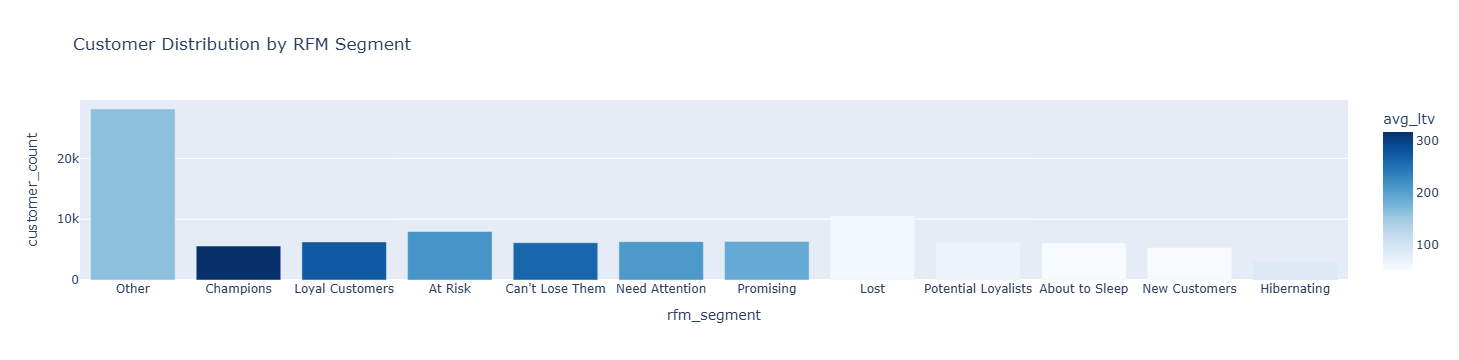

In [ ]:
import plotly.express as px  
import pandas as pd
from google.cloud import bigquery

def test_customer_rfm():
    query = f"""
    SELECT 
        rfm_segment,
        COUNT(*) as customer_count,
        ROUND(SUM(monetary), 2) as total_revenue,
        ROUND(AVG(monetary), 2) as avg_ltv
    FROM `{PROJECT_ID}.{DATASET_MARTS}.mart_customer_rfm`
    GROUP BY rfm_segment
    ORDER BY total_revenue DESC
    """
    
    try:
        df = client.query(query).to_dataframe()
        print("=" * 60)
        print("MART_CUSTOMER_RFM - SEGMENT DISTRIBUTION")
        print("=" * 60)
        print(df)
        print("=" * 60)
        
        fig = px.bar(
            df, 
            x='rfm_segment', 
            y='customer_count',
            title='Customer Distribution by RFM Segment',
            color='avg_ltv',
            color_continuous_scale='Blues'
        )
        fig.show()
        return df
    except Exception as e:
        print(f"Error: {e}")
        return pd.DataFrame()

df_rfm = test_customer_rfm()

## 8. Final Validation Summary

In [16]:
print("\n" + "=" * 60)
print("SETUP & TEST VALIDATION SUMMARY")
print("=" * 60)

all_passed = (
    not df_marts.empty and 
    not df_customer_summary.empty and 
    not df_rfm.empty
)

if all_passed:
    print("\nALL TESTS PASSED! Environment is ready for analysis!")
    print(f"\nYou have access to {len(df_marts)} mart tables")
    print("\nYou can proceed to create analysis notebooks!")
else:
    print("\nSome tests failed. Please check the errors above.")


SETUP & TEST VALIDATION SUMMARY

ALL TESTS PASSED! Environment is ready for analysis!

You have access to 21 mart tables

You can proceed to create analysis notebooks!
